In [ ]:
# Install required libraries
!pip install matplotlib networkx torchviz torchview torchvision torchsummary thop transformers

In [2]:
import os
# Set the environment variable to disable tokenizer parallelism
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
# Rest of the imports
import torch
import torch.nn as nn
from torchviz import make_dot
from torchsummary import summary
from thop import profile
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image, display
from transformers import AutoModel, AutoTokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


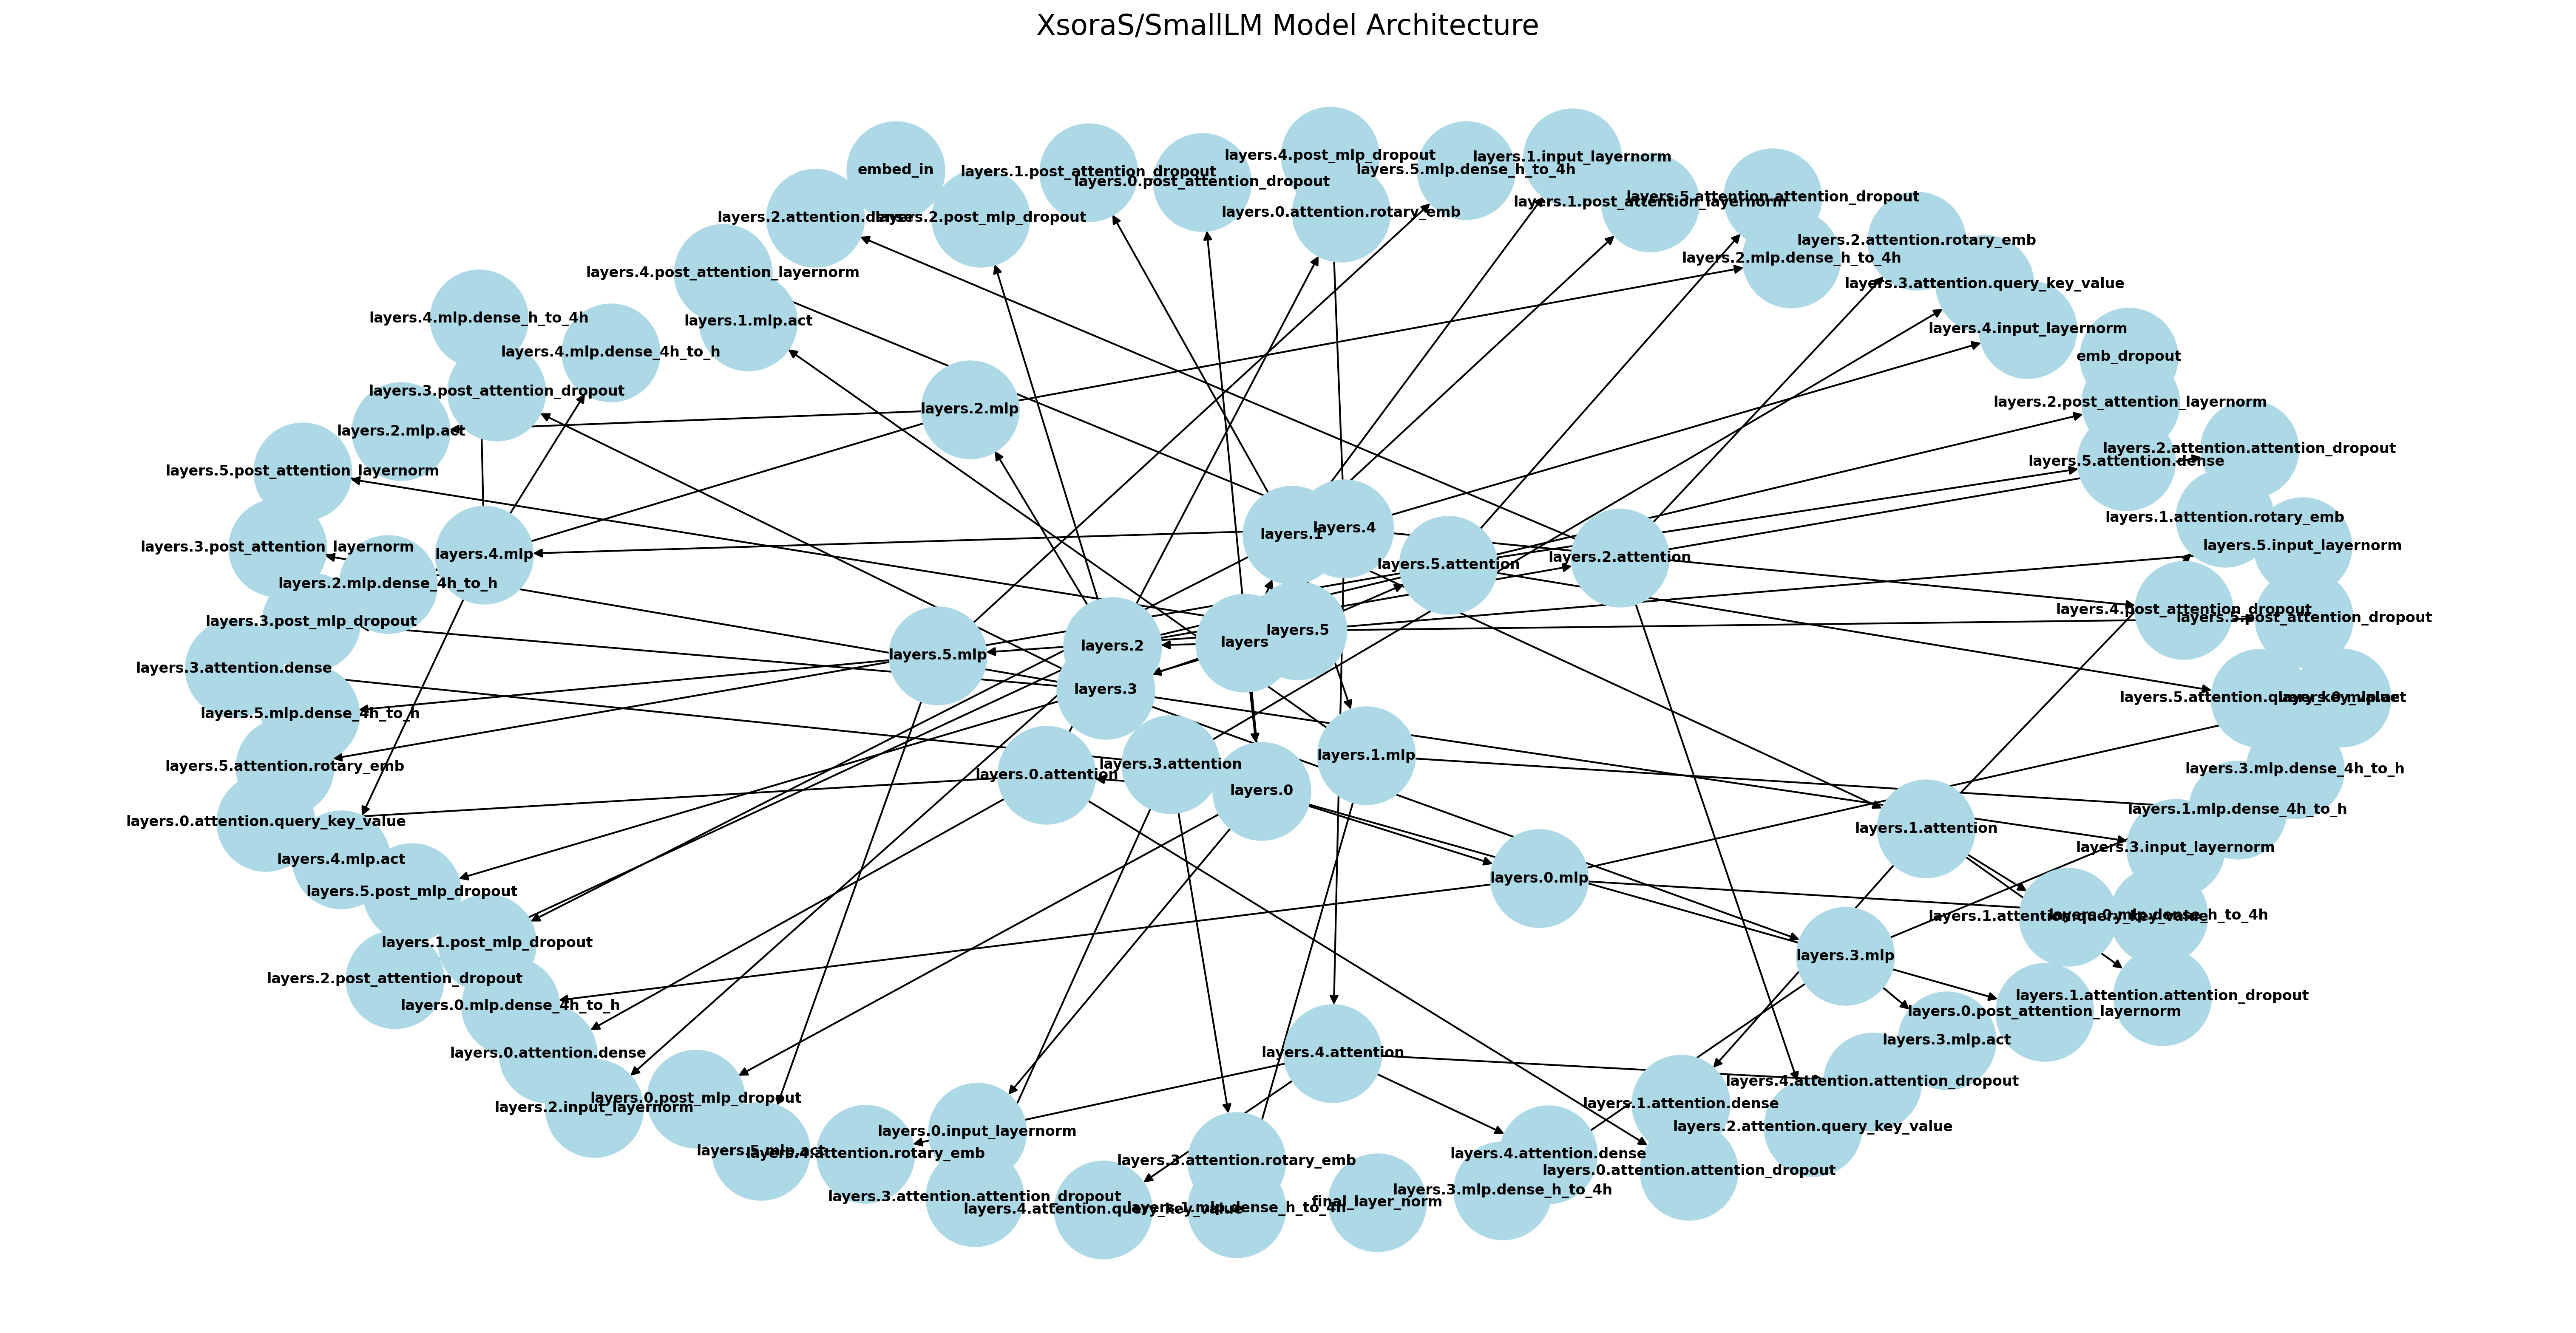

Total parameters: 7628800
Trainable parameters: 7628800

Output shape: torch.Size([1, 4, 128])


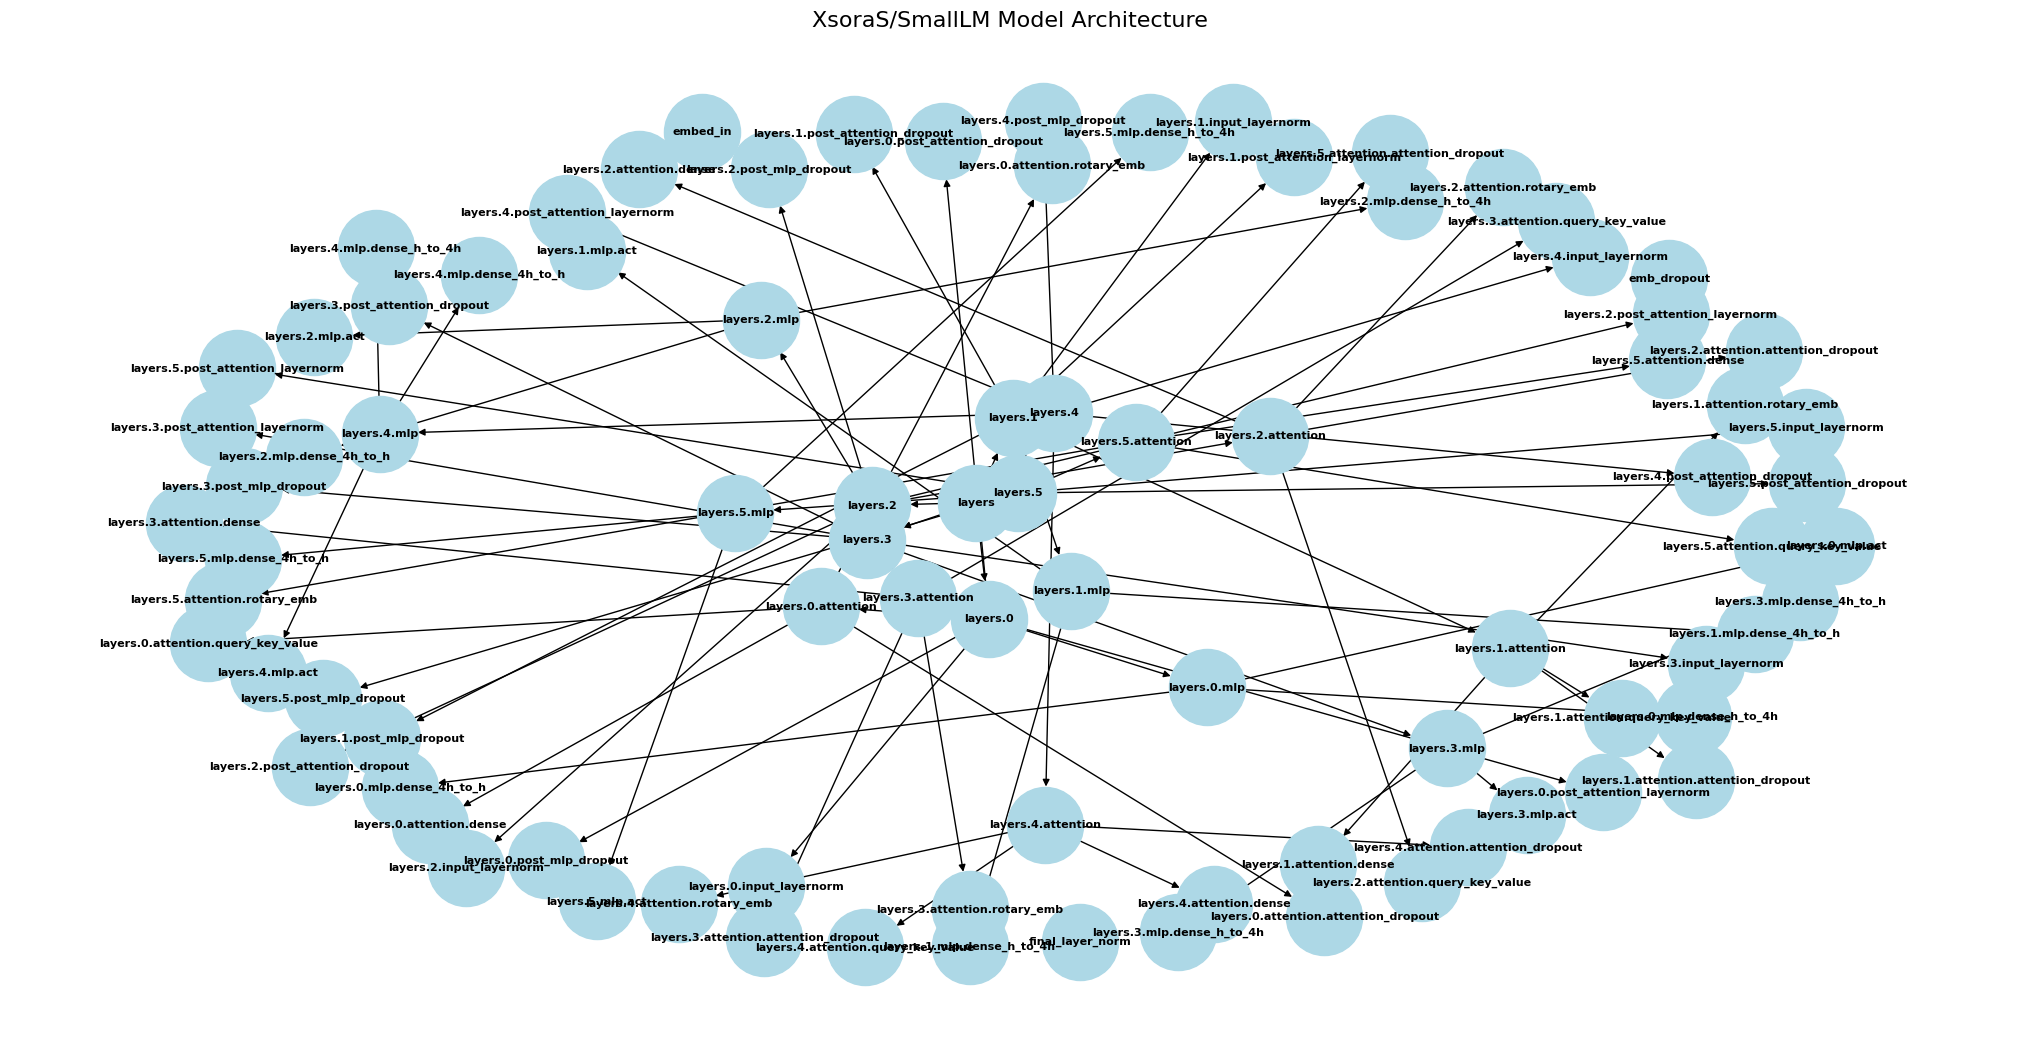

In [4]:
# Load the XsoraS/SmallLM model
model_name = "XsoraS/SmallLM"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Create a directed graph
G = nx.DiGraph()

def add_module_to_graph(module, parent_name=''):
    for name, child in module.named_children():
        full_name = f"{parent_name}.{name}" if parent_name else name
        G.add_node(full_name)
        if parent_name:
            G.add_edge(parent_name, full_name)
        add_module_to_graph(child, full_name)

# Build the graph
add_module_to_graph(model)

# Create a layout for our nodes 
layout = nx.spring_layout(G)

# Draw the graph
plt.figure(figsize=(20, 10))
nx.draw(G, layout, with_labels=True, node_color='lightblue', 
        node_size=3000, font_size=8, font_weight='bold', arrows=True)

# Add a title
plt.title("XsoraS/SmallLM Model Architecture", fontsize=16)

# Save the figure
plt.savefig("./images/smalllm_architecture.png", format="png", dpi=300, bbox_inches='tight')

# Display the image
display(Image(filename="./images/smalllm_architecture.png"))

# Print some basic model information
# print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
# print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Analyze model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

# Create a sample input and generate output to show shape
sample_text = "Hello, world!"
inputs = tokenizer(sample_text, return_tensors="pt")
outputs = model(**inputs)
print(f"\nOutput shape: {outputs.last_hidden_state.shape}")

In [5]:
# Examine output shape at each layer
def hook_fn(module, input, output):
    if isinstance(output, tuple):
        output = output[0]
    elif hasattr(output, 'last_hidden_state'):
        output = output.last_hidden_state
    print(f"{module.__class__.__name__} output shape: {output.shape}")

for name, module in model.named_modules():
    if not isinstance(module, nn.ModuleList):
        module.register_forward_hook(hook_fn)

_ = model(**inputs)

# Analyze activation distributions
activations = {}

def activation_hook(name):
    def hook(module, input, output):
        if isinstance(output, tuple):
            output = output[0]
        elif hasattr(output, 'last_hidden_state'):
            output = output.last_hidden_state
        activations[name] = output
    return hook

for name, module in model.named_modules():
    if isinstance(module, (nn.ReLU, nn.Linear, nn.LayerNorm)):
        module.register_forward_hook(activation_hook(name))

_ = model(**inputs)

for name, activation in activations.items():
    print(f"{name} activation stats:")
    print(f"  Mean: {activation.mean().item():.4f}")
    print(f"  Std: {activation.std().item():.4f}")
    print(f"  Min: {activation.min().item():.4f}")
    print(f"  Max: {activation.max().item():.4f}")

Embedding output shape: torch.Size([1, 4, 128])
Dropout output shape: torch.Size([1, 4, 128])
LayerNorm output shape: torch.Size([1, 4, 128])
Linear output shape: torch.Size([1, 4, 384])
GPTNeoXRotaryEmbedding output shape: torch.Size([4, 8])
Dropout output shape: torch.Size([1, 4, 4, 4])
Linear output shape: torch.Size([1, 4, 128])
GPTNeoXAttention output shape: torch.Size([1, 4, 128])
Dropout output shape: torch.Size([1, 4, 128])
LayerNorm output shape: torch.Size([1, 4, 128])
Linear output shape: torch.Size([1, 4, 512])
GELUActivation output shape: torch.Size([1, 4, 512])
Linear output shape: torch.Size([1, 4, 128])
GPTNeoXMLP output shape: torch.Size([1, 4, 128])
Dropout output shape: torch.Size([1, 4, 128])
GPTNeoXLayer output shape: torch.Size([1, 4, 128])
LayerNorm output shape: torch.Size([1, 4, 128])
Linear output shape: torch.Size([1, 4, 384])
GPTNeoXRotaryEmbedding output shape: torch.Size([4, 8])
Dropout output shape: torch.Size([1, 4, 4, 4])
Linear output shape: torch.Size

In [6]:
# Analyze gradient flow
model.zero_grad()
outputs = model(**inputs)
loss = outputs.last_hidden_state.sum()
loss.backward()

for name, param in model.named_parameters():
    if param.requires_grad and param.grad is not None:
        print(f"{name} gradient stats:")
        print(f"  Mean: {param.grad.mean().item():.4f}")
        print(f"  Std: {param.grad.std().item():.4f}")
        print(f"  Min: {param.grad.min().item():.4f}")
        print(f"  Max: {param.grad.max().item():.4f}")

Embedding output shape: torch.Size([1, 4, 128])
Dropout output shape: torch.Size([1, 4, 128])
LayerNorm output shape: torch.Size([1, 4, 128])
Linear output shape: torch.Size([1, 4, 384])
GPTNeoXRotaryEmbedding output shape: torch.Size([4, 8])
Dropout output shape: torch.Size([1, 4, 4, 4])
Linear output shape: torch.Size([1, 4, 128])
GPTNeoXAttention output shape: torch.Size([1, 4, 128])
Dropout output shape: torch.Size([1, 4, 128])
LayerNorm output shape: torch.Size([1, 4, 128])
Linear output shape: torch.Size([1, 4, 512])
GELUActivation output shape: torch.Size([1, 4, 512])
Linear output shape: torch.Size([1, 4, 128])
GPTNeoXMLP output shape: torch.Size([1, 4, 128])
Dropout output shape: torch.Size([1, 4, 128])
GPTNeoXLayer output shape: torch.Size([1, 4, 128])
LayerNorm output shape: torch.Size([1, 4, 128])
Linear output shape: torch.Size([1, 4, 384])
GPTNeoXRotaryEmbedding output shape: torch.Size([4, 8])
Dropout output shape: torch.Size([1, 4, 4, 4])
Linear output shape: torch.Size

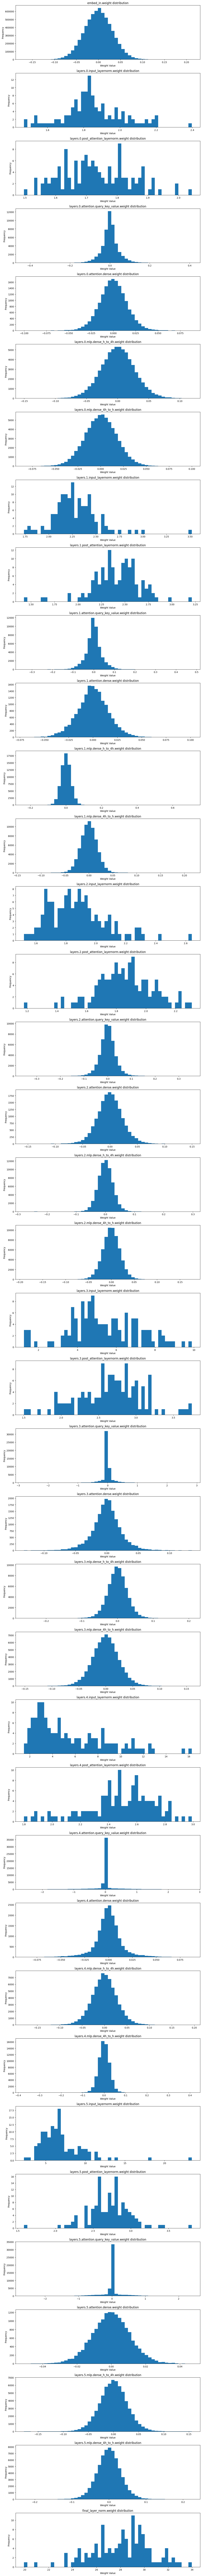

In [7]:
# Visualize weight distributions
weight_params = [(name, param) for name, param in model.named_parameters() if 'weight' in name]
num_weight_layers = len(weight_params)

fig, axes = plt.subplots(num_weight_layers, 1, figsize=(12, 4*num_weight_layers))
axes = axes.flatten() if num_weight_layers > 1 else [axes]

for i, (name, param) in enumerate(weight_params):
    ax = axes[i]
    ax.hist(param.detach().cpu().numpy().flatten(), bins=50)
    ax.set_title(f'{name} distribution')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Weight Value')

plt.tight_layout()
plt.show()

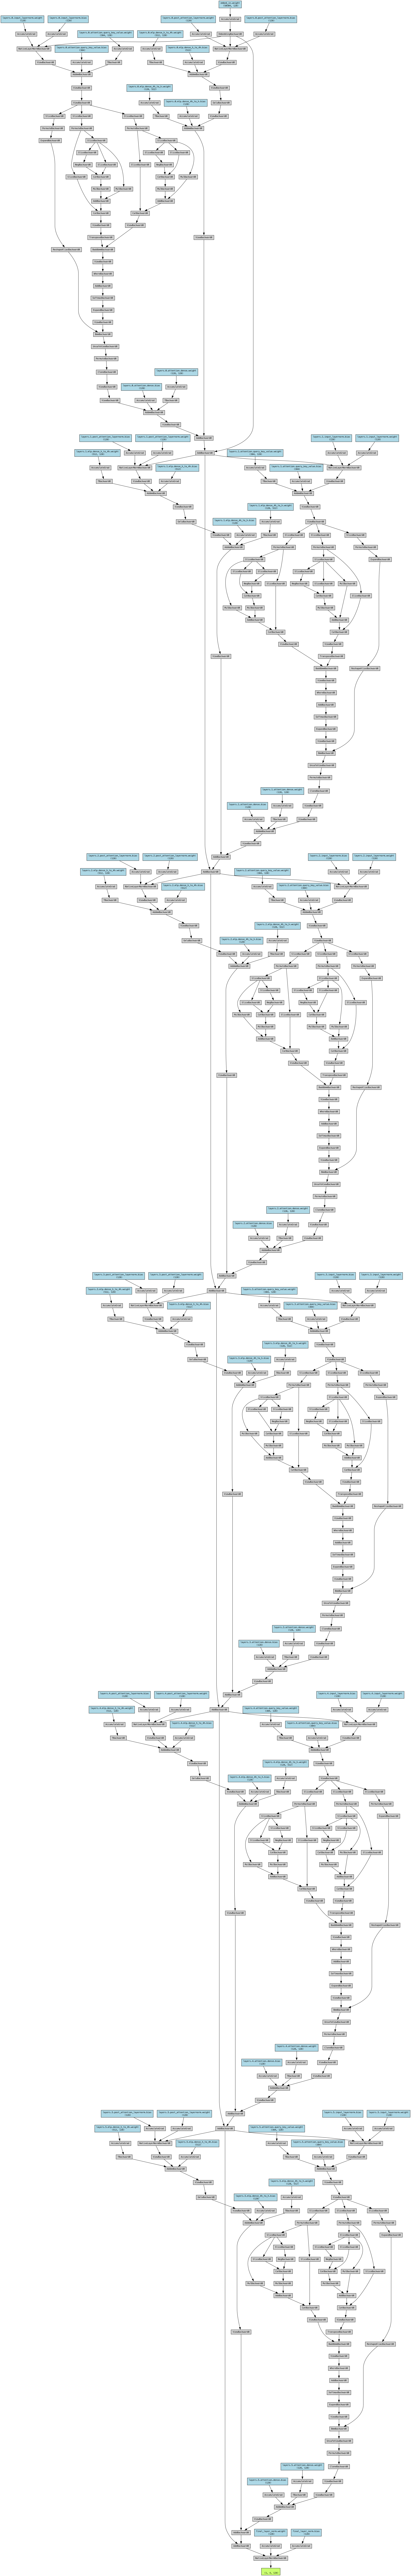

GPTNeoXModel(
  (embed_in): Embedding(50304, 128)
  (emb_dropout): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0-5): 6 x GPTNeoXLayer(
      (input_layernorm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (post_attention_layernorm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (post_attention_dropout): Dropout(p=0.0, inplace=False)
      (post_mlp_dropout): Dropout(p=0.0, inplace=False)
      (attention): GPTNeoXAttention(
        (rotary_emb): GPTNeoXRotaryEmbedding()
        (query_key_value): Linear(in_features=128, out_features=384, bias=True)
        (dense): Linear(in_features=128, out_features=128, bias=True)
        (attention_dropout): Dropout(p=0.0, inplace=False)
      )
      (mlp): GPTNeoXMLP(
        (dense_h_to_4h): Linear(in_features=128, out_features=512, bias=True)
        (dense_4h_to_h): Linear(in_features=512, out_features=128, bias=True)
        (act): GELUActivation()
      )
    )
  )
  (final_layer_norm): LayerNorm((

In [8]:
# Create and visualize the computational graph
graph = make_dot(outputs.last_hidden_state, params=dict(model.named_parameters()))
os.environ["PATH"] += os.pathsep + "/usr/local/bin/dot"

# Create images folder if it doesn't exist
images_folder = "images"
os.makedirs(images_folder, exist_ok=True)

# Generate the image file path
temp_filename = "neural_structure"
image_path = os.path.join(images_folder, f"{temp_filename}.png")

# Render and save the graph
graph.render(os.path.join(images_folder, temp_filename), format="png", cleanup=True)

# Display the image
display(Image(filename=image_path))

# Print model structure and output shape
print(model)
print("Output shape:", outputs.last_hidden_state.shape)

In [9]:
# Layer-wise analysis
def layer_analysis(module, input, output):
    if isinstance(output, tuple):
        output = output[0]
    elif hasattr(output, 'last_hidden_state'):
        output = output.last_hidden_state
    print(f"\nLayer: {module.__class__.__name__}")
    print(f"Input shape: {input[0].shape}")
    print(f"Output shape: {output.shape}")
    print(f"Parameters: {sum(p.numel() for p in module.parameters())}")
    if hasattr(module, 'weight'):
        print(f"Weight stats:")
        print(f"  Mean: {module.weight.mean().item():.4f}")
        print(f"  Std: {module.weight.std().item():.4f}")
    if hasattr(module, 'bias') and module.bias is not None:
        print(f"Bias stats:")
        print(f"  Mean: {module.bias.mean().item():.4f}")
        print(f"  Std: {module.bias.std().item():.4f}")

for name, module in model.named_modules():
    if isinstance(module, (nn.Linear, nn.LayerNorm)):
        module.register_forward_hook(layer_analysis)

_ = model(**inputs)

Embedding output shape: torch.Size([1, 4, 128])
Dropout output shape: torch.Size([1, 4, 128])
LayerNorm output shape: torch.Size([1, 4, 128])

Layer: LayerNorm
Input shape: torch.Size([1, 4, 128])
Output shape: torch.Size([1, 4, 128])
Parameters: 256
Weight stats:
  Mean: 1.8535
  Std: 0.1654
Bias stats:
  Mean: 0.1595
  Std: 0.4270
Linear output shape: torch.Size([1, 4, 384])

Layer: Linear
Input shape: torch.Size([1, 4, 128])
Output shape: torch.Size([1, 4, 384])
Parameters: 49536
Weight stats:
  Mean: 0.0010
  Std: 0.0422
Bias stats:
  Mean: 0.6146
  Std: 9.8483
GPTNeoXRotaryEmbedding output shape: torch.Size([4, 8])
Dropout output shape: torch.Size([1, 4, 4, 4])
Linear output shape: torch.Size([1, 4, 128])

Layer: Linear
Input shape: torch.Size([1, 4, 128])
Output shape: torch.Size([1, 4, 128])
Parameters: 16512
Weight stats:
  Mean: -0.0001
  Std: 0.0154
Bias stats:
  Mean: 0.0002
  Std: 0.0276
GPTNeoXAttention output shape: torch.Size([1, 4, 128])
Dropout output shape: torch.Size

In [10]:
# Compute parameters and estimate FLOPs
def count_parameters_and_estimate_flops(model, inputs):
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    
    # Estimate FLOPs (this is a rough estimate)
    # I'll assume each parameter is used once per token
    input_ids = inputs['input_ids']
    seq_length = input_ids.shape[1]
    estimated_flops = total_params * seq_length
    
    return estimated_flops, total_params

estimated_flops, params = count_parameters_and_estimate_flops(model, inputs)
print(f"\nEstimated FLOPs: {estimated_flops/1e9:.2f}G")
print(f"Parameters: {params/1e6:.2f}M")



Estimated FLOPs: 0.03G
Parameters: 7.63M


In [11]:
print("\nSummary of XsoraS/SmallLM Model Analysis:")
print("1. Model Loading and Basic Information:")
print(f"   - Model: XsoraS/SmallLM")
print(f"   - Total parameters: {total_params}")
print(f"   - Trainable parameters: {trainable_params}")
print(f"   - Output shape for sample input: {outputs.last_hidden_state.shape}")

print("\n2. Model Architecture:")
print("   - The model's architecture has been printed, showing the structure of the transformer layers.")

print("\n3. Layer-wise Analysis:")
print("   - Output shapes for each layer have been printed, showing how the data flows through the model.")
print("   - Detailed statistics for Linear and LayerNorm layers have been provided, including input/output shapes and parameter counts.")

print("\n4. Activation Analysis:")
print("   - Statistics (mean, std, min, max) for activations of ReLU, Linear, and LayerNorm layers have been calculated.")
print("   - This helps in understanding the behavior of different parts of the network during forward pass.")

print("\n5. Weight Distribution:")
print("   - Histograms of weight distributions for each layer have been plotted.")
print("   - This visualization helps in understanding the learned representations and potential issues like vanishing gradients.")

print("\n6. Gradient Flow Analysis:")
print("   - Gradient statistics for each parameter have been calculated after a backward pass.")
print("   - This helps in identifying potential issues with gradient flow during training.")

print("\n7. Computational Complexity:")
print(f"   - Estimated FLOPs: {estimated_flops/1e9:.2f}G")
print(f"   - Parameters: {params/1e6:.2f}M")
print("   - These metrics give an idea of the model's computational requirements and size.")

print("\nThis analysis provides a comprehensive overview of the XsoraS/SmallLM model, including its architecture, ")
print("parameter distributions, activation patterns, and computational requirements. This information can be valuable ")
print("for understanding the model's behavior, optimizing its performance, and identifying potential areas for improvement.")
print("\nNote: The FLOPs estimation is approximate and based on a simple calculation. For more accurate results, ")
print("a detailed analysis of the model's specific architecture and operations would be required.")


Summary of XsoraS/SmallLM Model Analysis:
1. Model Loading and Basic Information:
   - Model: XsoraS/SmallLM
   - Total parameters: 7628800
   - Trainable parameters: 7628800
   - Output shape for sample input: torch.Size([1, 4, 128])

2. Model Architecture:
   - The model's architecture has been printed, showing the structure of the transformer layers.

3. Layer-wise Analysis:
   - Output shapes for each layer have been printed, showing how the data flows through the model.
   - Detailed statistics for Linear and LayerNorm layers have been provided, including input/output shapes and parameter counts.

4. Activation Analysis:
   - Statistics (mean, std, min, max) for activations of ReLU, Linear, and LayerNorm layers have been calculated.
   - This helps in understanding the behavior of different parts of the network during forward pass.

5. Weight Distribution:
   - Histograms of weight distributions for each layer have been plotted.
   - This visualization helps in understanding the 